# Locally Linear Embedding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.utils import check_random_state

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

## Find k nearest neighbors

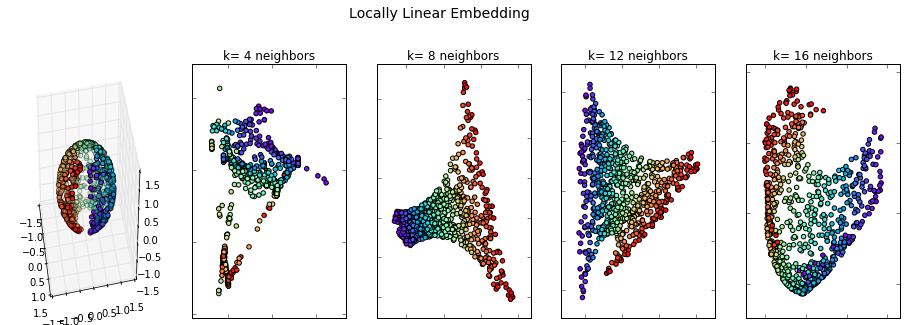

In [2]:
n_samples = 1000

# create our sphere
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# sever the poles from the sphere
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# plot our dataset
fig = plt.figure(figsize=(16, 10))
plt.suptitle("Locally Linear Embedding", fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T

# perform local linear embedding 
neighbors = np.arange(4, 20, 4)

for i, neighbor in enumerate(neighbors):
    trans_data = manifold.LocallyLinearEmbedding(neighbor, 2).fit_transform(sphere_data).T
    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow);
    ax.xaxis.set_major_formatter(NullFormatter());
    ax.yaxis.set_major_formatter(NullFormatter());
    plt.title('k= ' +str(neighbor) + ' neighbors')
    plt.axis('tight');
plt.show();

## Local Linear Combinations

In [3]:
def barycenter_weights(X, Z, reg=1e-3):
    """Compute barycenter weights of X from Y along the first axis
    We estimate the weights to assign to each point in Y[i] to recover
    the point X[i]. The barycenter weights sum to 1.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_dim)
    Z : array-like, shape (n_samples, n_neighbors, n_dim)
    reg : float, optional
        amount of regularization to add for the problem to be
        well-posed in the case of n_neighbors > n_dim
    Returns
    -------
    B : array-like, shape (n_samples, n_neighbors)
    """
    n_samples, n_neighbors = X.shape[0], Z.shape[1]
    B = np.empty((n_samples, n_neighbors), dtype=X.dtype)
    v = np.ones(n_neighbors, dtype=X.dtype)

    # this might raise a LinalgError if G is singular and has trace
    # zero
    for i, A in enumerate(Z.transpose(0, 2, 1)):
        C = A.T - X[i]  # broadcasting
        G = np.dot(C, C.T)
        trace = np.trace(G)
        if trace > 0:
            R = reg * trace
        else:
            R = reg
        # add regularization term to diagonal of G
        G.flat[::Z.shape[1] + 1] += R
        # solve linear system of equations Gw=v
        w = solve(G, v, sym_pos=True)
        # rescale weights
        B[i, :] = w / np.sum(w)
    return B

In [4]:
from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix, find
from scipy.sparse.linalg import eigsh

def barycenter_kneighbors_graph(X, n_neighbors, reg=1e-3, n_jobs=None):
    """Computes the barycenter weighted graph of k-Neighbors for points in X
    Parameters
    ----------
    X : {array-like, NearestNeighbors}
        Sample data, shape = (n_samples, n_features), in the form of a
        numpy array or a NearestNeighbors object.
    n_neighbors : int
        Number of neighbors for each sample.
    reg : float, optional
        Amount of regularization when solving the least-squares
        problem. Only relevant if mode='barycenter'. If None, use the
        default.
    n_jobs : int or None, optional (default=None)
        The number of parallel jobs to run for neighbors search.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    Returns
    -------
    A : sparse matrix in CSR format, shape = [n_samples, n_samples]
        A[i, j] is assigned the weight of edge that connects i to j.
    See also
    --------
    sklearn.neighbors.kneighbors_graph
    sklearn.neighbors.radius_neighbors_graph
    """
    knn = NearestNeighbors(n_neighbors + 1, n_jobs=n_jobs).fit(X)
    X = knn._fit_X
    n_samples = X.shape[0]
    ind = knn.kneighbors(X, return_distance=False)[:, 1:]
    data = barycenter_weights(X, X[ind], reg=reg)
    indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)
    return csr_matrix((data.ravel(), ind.ravel(), indptr),
                      shape=(n_samples, n_samples))

In [5]:
from sklearn.metrics import pairwise_distances

# function that outputs N x k matrix with k nearest neighbors for each observation in X
def nearest_neighbors(X, k):
    # we use k+1 here since Xi will have the shortest distance to itself
    knn_matrix = np.zeros((len(X), k))
    # compute pairwise distances
    dist_matrix = pairwise_distances(X)
    # for each row find indices of k nearest neighbors
    for i in range(len(X)):
        knn_matrix[i] = dist_matrix[i,:].argsort()[1:k+1]
    return knn_matrix

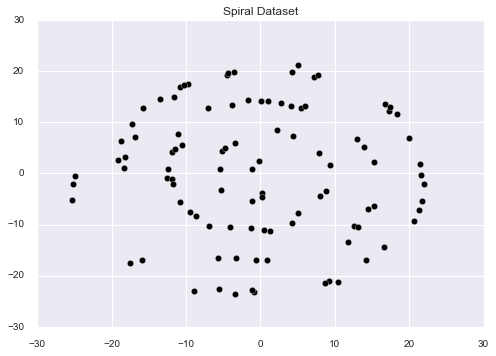

In [6]:
import seaborn as sns
sns.set()
plt.style.use('seaborn-notebook')

# spiral dataset
n = 100
u = np.sqrt(np.random.rand(n,1)) * 1440 * (2*np.pi)/360
x = -np.cos(u)*u + np.random.randn(n,1)*0.5
y = np.sin(u)*u + np.random.randn(n,1)*0.5
X = np.hstack((x,y))

plt.scatter(x, y, c = 'black',s=40)
plt.title('Spiral Dataset');

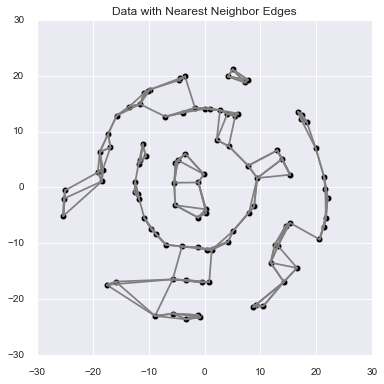

In [7]:
# loop through each data point and draw lines to nearest neighbors
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], alpha=1, c='black', s=40);
k = 3
neighbors = nearest_neighbors(X, k).astype('int')
for i in range(len(X)):
    knn = neighbors[i]
    for j in range(k):
        plt.plot(X[[i, knn[j]], 0], X[[i, knn[j]], 1], c='gray')

plt.title('Data with Nearest Neighbor Edges');

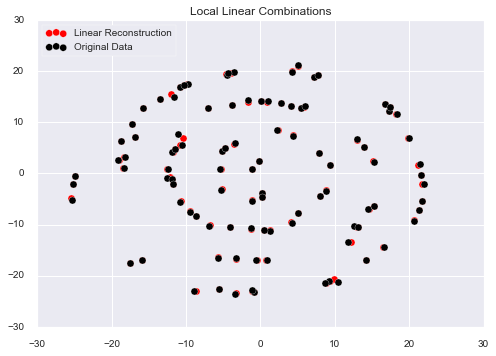

In [8]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
W = barycenter_kneighbors_graph(X, n_neighbors=k)

linear_combos = []
neighborhood_weights = []
for i in range(len(X)):
    weights = W.toarray()[i][neighbors[i]]
    neighborhood = X[neighbors[i]]
    weighted_neighbors = weights.reshape(-1,1)*neighborhood
    lin_x1 = np.sum(weighted_neighbors[:,0])
    lin_x2 = np.sum(weighted_neighbors[:,1])
    linear_combos.append([lin_x1, lin_x2])
    neighborhood_weights.append(weights)
linear_X = np.array(linear_combos)
plt.scatter(linear_X[:,0], linear_X[:,1], c='red', s=50, label='Linear Reconstruction')
plt.scatter(X[:,0], X[:,1], c='black', s=50, label='Original Data')
plt.title('Local Linear Combinations')
plt.legend(loc='upper left');

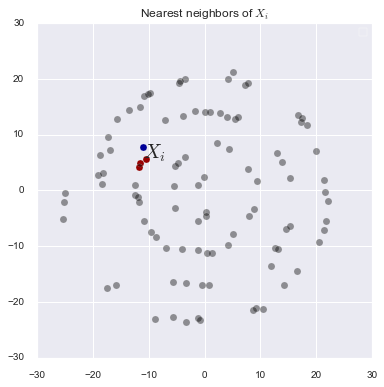

In [9]:
# neighbors for a given xi (maximum reconstruction error)
ix = np.argmax([np.linalg.norm(X[i] - linear_X[i]) for i in range(len(X))])
xi_neighbors = neighbors[ix] # indices of neighbors
plt.figure(figsize=(6,6))
plt.scatter(X[ix, 0], X[ix, 1], c='blue', s=50)
plt.text(X[ix, 0], X[ix, 1]-2, s='$X_i$', size=20)
plt.scatter(X[xi_neighbors, 0], X[xi_neighbors, 1], c='red', s=50)
plt.scatter(X[:,0], X[:,1], alpha=0.4, c='black', s=50)
plt.title('Nearest neighbors of $X_i$')
plt.legend('');

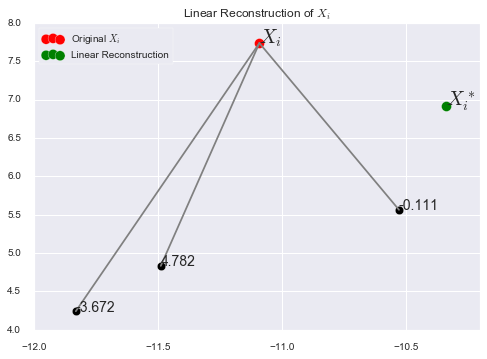

In [10]:
xi_weights = np.round(neighborhood_weights[ix],3)
plt.scatter(X[ix, 0], X[ix, 1], c='red', s=100, alpha=1, label='Original $X_i$')
plt.text(X[ix, 0], X[ix, 1], s='$X_i$', size=20)
plt.scatter(X[xi_neighbors, 0], X[xi_neighbors, 1], c='black', alpha=1, s=70)
plt.scatter(linear_X[ix,0], linear_X[ix,1], c='green', s=100, label='Linear Reconstruction')
plt.text(linear_X[ix,0], linear_X[ix,1], s='$X_i^*$', size=20)
for i in range(len(xi_neighbors)):
    plt.text(X[xi_neighbors[i], 0], X[xi_neighbors[i], 1], s=str(xi_weights[i]), size=14)
    plt.plot(X[[ix, xi_neighbors[i]], 0], X[[ix, xi_neighbors[i]], 1], c='gray')
plt.title('Linear Reconstruction of $X_i$')
plt.legend(loc='upper left');

In [11]:
# reconstruction errors
np.linalg.norm(X[ix] - linear_X[ix])
np.sum([np.linalg.norm(X[i] - linear_X[i]) for i in range(len(X))])

1.1100722205915752

12.414623785445503

## Toy datasets

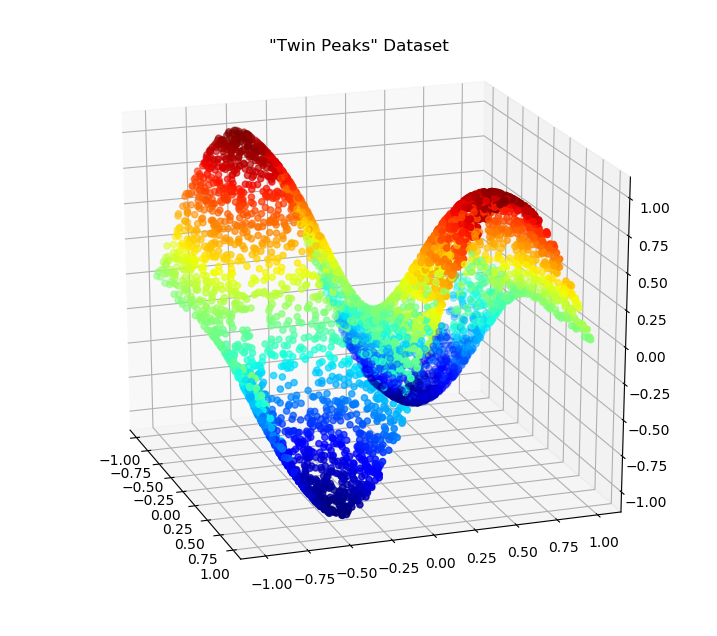

In [12]:
# twin peaks dataset
plt.style.use('default')
n = 5000
param = 1
xy = 1 - 2 * np.random.rand(2, n)
p = np.array([xy[1, :], xy[0, :], param * np.sin(np.pi * xy[0, :]) * np.tanh(3 * xy[1, :])]).T
color = p[:, 2]
fig = plt.figure(figsize = (9, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:, 0], p[:, 1], p[:, 2], c=color, cmap=plt.cm.jet)
plt.title('"Twin Peaks" Dataset', size=12)
ax.view_init(20, -19);

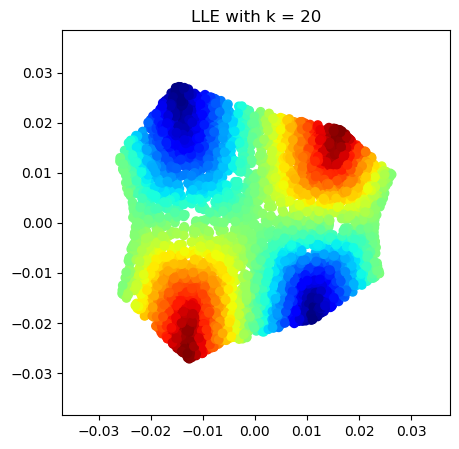

In [13]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=20) 
X_reduced = lle.fit_transform(p)
fig = plt.figure(figsize = (5, 5))
plt.title('LLE with k = 20', size=12)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, cmap=plt.cm.jet);

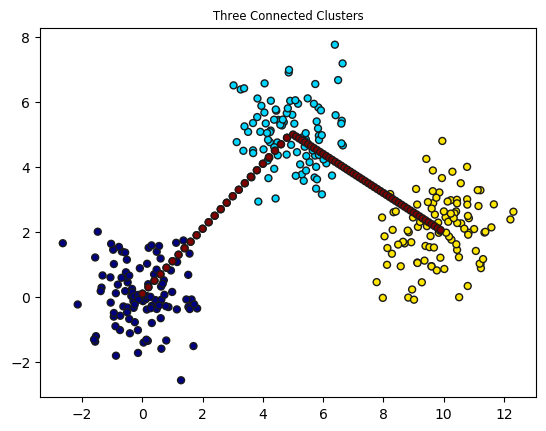

In [14]:
from sklearn.datasets import make_blobs
plt.title("Three Connected Clusters", fontsize='small')
X1, Y1 = make_blobs(n_samples=300,n_features=2, centers=[[0,0], [5,5], [10,2]])
t = np.arange(0,1,0.02)
l1 = np.array((t*5, t*5)).reshape(50,2)
l2 = np.hstack((np.array(5+5*t).reshape(-1,1),np.array(5+t*-3).reshape(-1,1)))
X = np.vstack((X1, l1, l2))
Y = np.vstack((Y1.reshape(-1,1), np.repeat(3,100).reshape(-1,1)))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y.reshape(400,),
            s=25, edgecolor='k', cmap=plt.cm.jet);

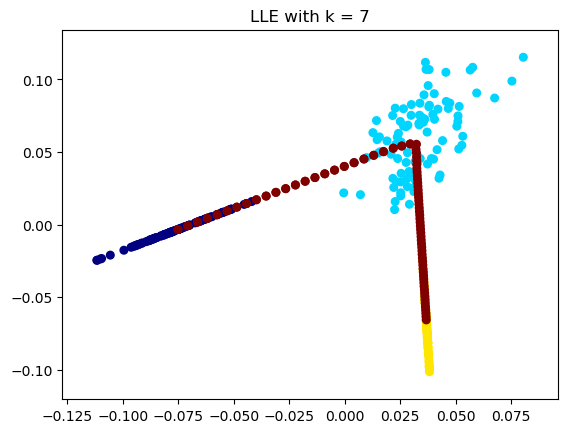

In [15]:
k = 7
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=k) 
X_reduced = lle.fit_transform(X)
plt.title('LLE with k = ' + str(k), size=12)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y.reshape(400,), s=30, cmap=plt.cm.jet);

## Handwritten digits

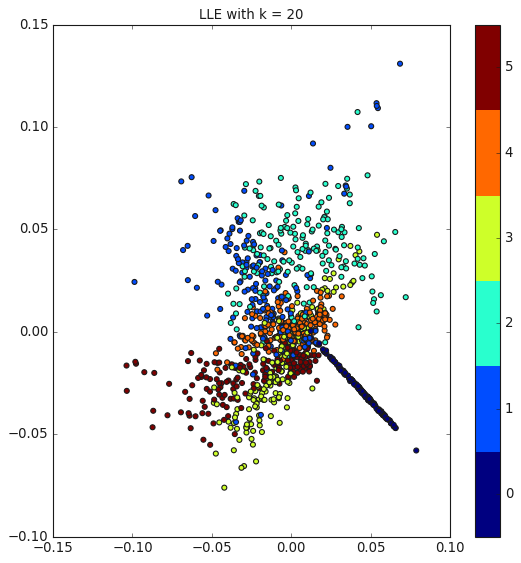

In [16]:
from sklearn import datasets
digits = datasets.load_digits(n_class=6)
data = digits.data
labels = digits.target
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=30) 
X_reduced = lle.fit_transform(data)
fig = plt.figure(figsize = (8, 8))
plt.title('LLE with k = 20', size=12)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap=plt.cm.get_cmap('jet', 6))
plt.colorbar(ticks=range(6))
plt.clim(-0.5, 5.5);

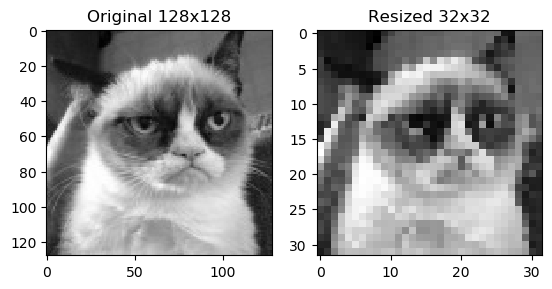

In [17]:
import cv2
import matplotlib.image as img
from skimage.color import rgb2gray
plt.style.use('default')

# read in the image
image = cv2.imread("data/cat3.jpg")
# convert to gray and resize
image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
res = cv2.resize(image, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
plt.subplot(121)
plt.title('Original 128x128')
plt.imshow(image,cmap='gray')
plt.subplot(122)
plt.title('Resized 32x32')
plt.imshow(res,cmap='gray')
plt.show();

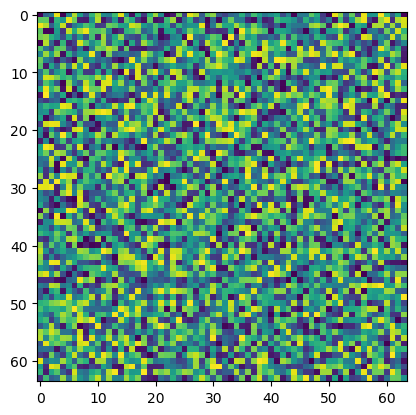

In [18]:
# create image with random noise
test_img = 255*np.random.rand(64, 64)
plt.imshow(test_img);

In [19]:
# iterate and create shifted images
images = []
for i in range(33):
    for j in range(33):
        tmp = np.copy(test_img)
        # slide the cat image along the background
        tmp[i:i+32, j:j+32] = res
        images.append(tmp);

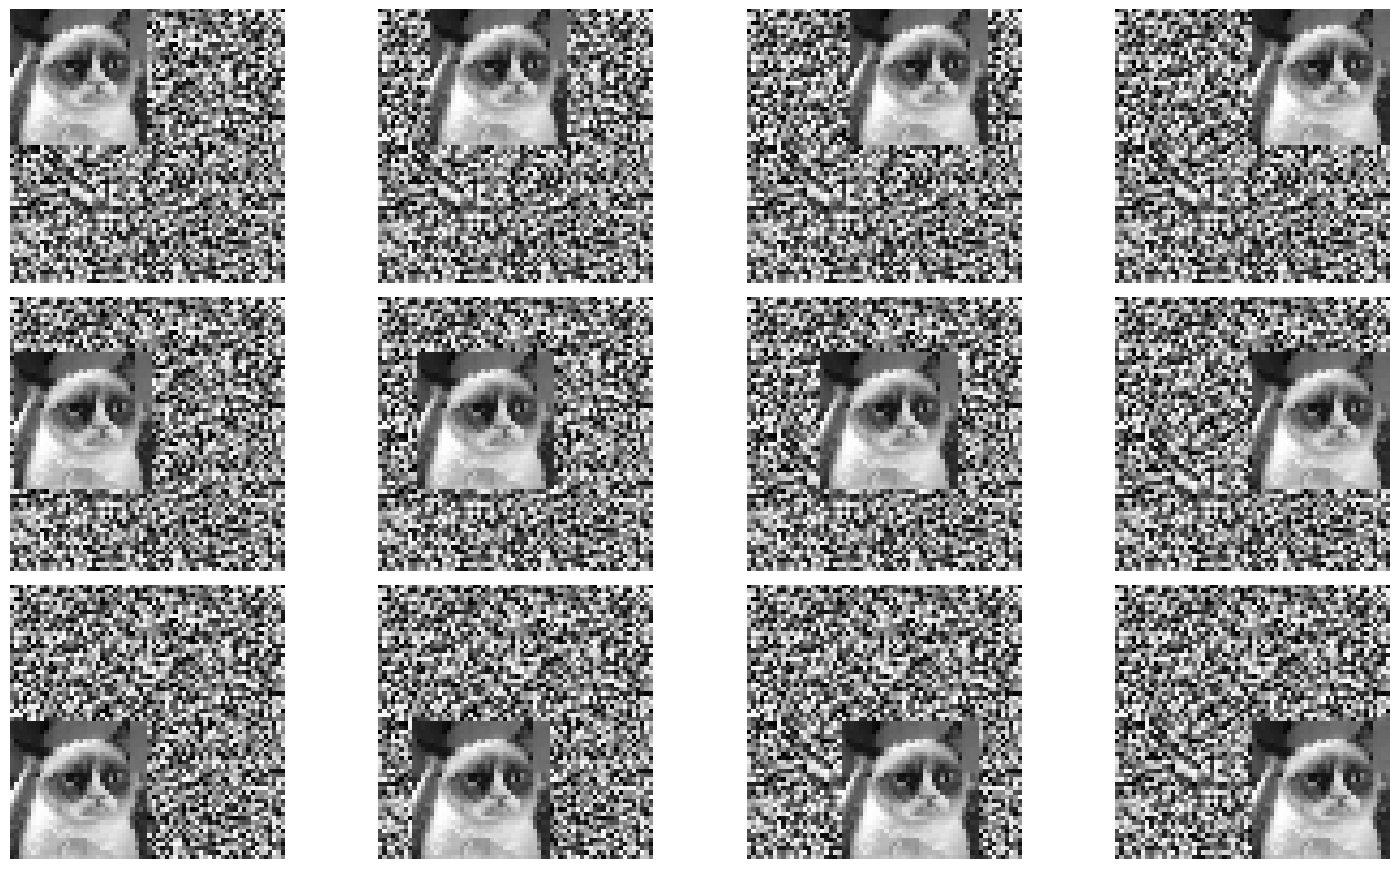

In [20]:
# plot some of the generated images
F = plt.figure(figsize=(15,10))
G = plt.GridSpec(3, 4, left=.01, right=.99, bottom=0.05, top=0.9, wspace=.01, 
                 hspace=0.05, figure=F)
ax = plt.subplot(G[0])
_ = ax.imshow(images[0], cmap='gray')
selected_images = [0, 12, 24, 32, 430, 438, 446, 461, 1056, 1064, 1078, 1088]
ax.set_axis_off()
ax.set_aspect('equal')
for i in range(1, 12):
    ax = plt.subplot(G[i])
    _ = ax.imshow(images[selected_images[i]], cmap='gray')
    ax.set_axis_off()
    ax.set_aspect('equal');

In [21]:
# get dimensions, number samples
np.array(images).shape
64*64

(1089, 64, 64)

4096

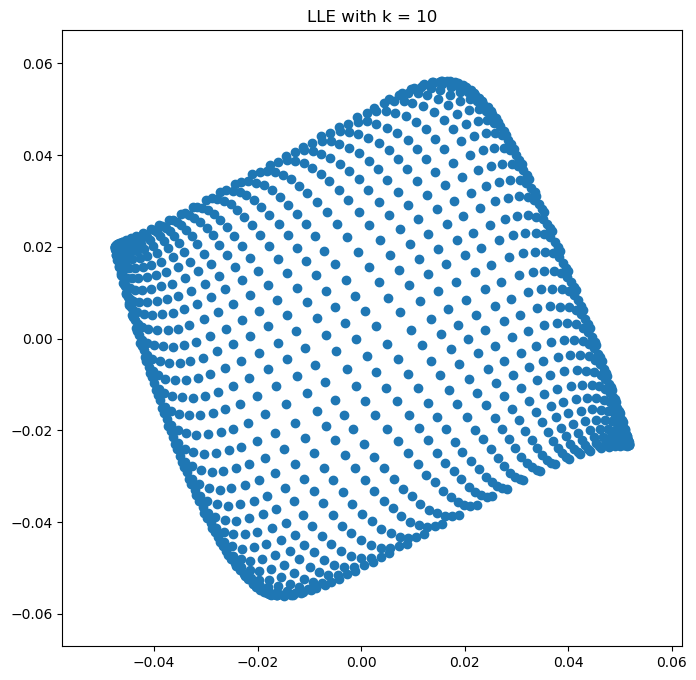

In [22]:
X = np.array(images).reshape(1089, 4096)
k = 10
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors=k)
X_reduced = lle.fit_transform(X)
fig = plt.figure(figsize = (8, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.title('LLE with k = '+str(k), size=12);

In [23]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap, zoom=1),
                                      proj[i])
            ax.add_artist(imagebox)
        for i in selected_images:
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap='gray'), 
                proj[i])
            ax.add_artist(imagebox)

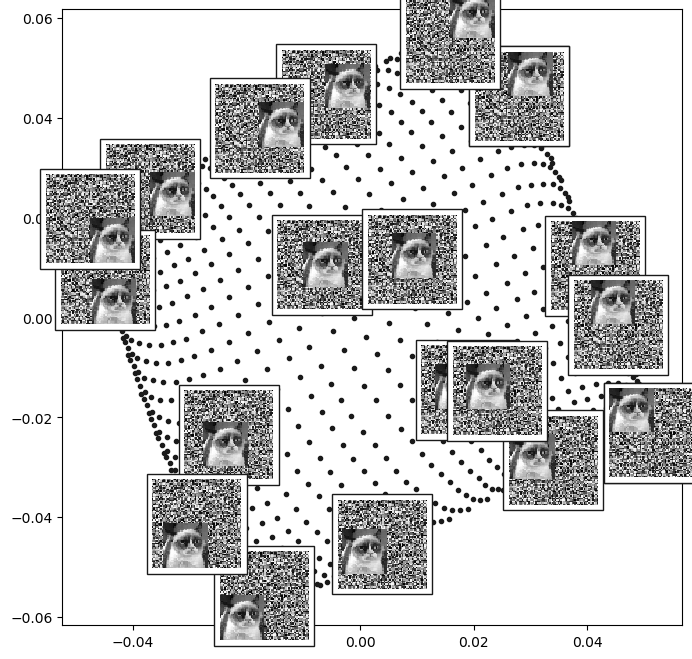

In [24]:
plt.figure(figsize=(8,8))
plot_components(X,
                model=LocallyLinearEmbedding(n_components=2, n_neighbors=k),
                thumb_frac=0.3,
                images=images);